<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-1:-Otsu-and-HSV-Thresholding-(5-marks)" data-toc-modified-id="Task-1:-Otsu-and-HSV-Thresholding-(5-marks)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task 1: Otsu and HSV Thresholding (5 marks)</a></span><ul class="toc-item"><li><span><a href="#hsv" data-toc-modified-id="hsv-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>hsv</a></span></li></ul></li><li><span><a href="#Task-2:-Counting-the-number-of-cells-(5-marks)" data-toc-modified-id="Task-2:-Counting-the-number-of-cells-(5-marks)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task 2: Counting the number of cells (5 marks)</a></span><ul class="toc-item"><li><span><a href="#median-filter" data-toc-modified-id="median-filter-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>median filter</a></span></li><li><span><a href="#two-pass-connected-components" data-toc-modified-id="two-pass-connected-components-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>two pass connected components</a></span></li></ul></li><li><span><a href="#benchmark-on-four-images" data-toc-modified-id="benchmark-on-four-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>benchmark on four images</a></span></li></ul></div>

#  Basic image processing, thresholding, count cells

# Task 1: Otsu and HSV Thresholding (5 marks)

thresh 202


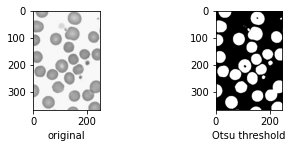

In [451]:
'''
0 / b - background
1 / f - foreground
'''
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math

def myimshow(img1, img2, t):
    
    fig = plt.figure()
    
    ax1 = fig.add_subplot(2,2,1)
#     ax1.imshow(np.random.rand(8, 90), interpolation='nearest')

    ax1.set_xlabel("original")
    ax1.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    
    ax2 = fig.add_subplot(2,2,2)
    ax2.set_xlabel(t)
    ax2.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
    
'''
0 / b - background
1 / f - foreground
use within class variance
'''

def otsu_thresholding(gray):
    # Compute histogram and probabilities of each intensity pixel
    hist, bins = np.histogram(gray, np.array(range(0, 257))) # ensure size 256, Compute histogram and probabilities of each intensity pixel
    hist = cv.calcHist([gray], [0], None, [255], [0,255])
    total = gray.shape[0] * gray.shape[1]
    
    within_var = math.inf
    thresh = 0
    
    for t in range(len(hist)):
        hb, hf = np.split(hist, [t])
        if np.sum(hb) == 0 or np.sum(hf) == 0: # avoid divide by zero
            continue

        w0 = np.sum(hb) / total #  Setup initial 𝜔𝑖(0) and μ𝑖(0)
        w1 = np.sum(hf) / total
    
        mub = np.sum([i * freq for i, freq in enumerate(hb)]) / np.sum(hb) # mean for discrete random variable
        muf = np.sum([(i+len(hb)) * freq for i, freq in enumerate(hf)]) / np.sum(hf) # (i+len(hb)) - add on from end of previous bin
        
        var0 = np.sum([((i - mub)**2) * freq for i, freq in enumerate(hb)]) / np.sum(hb)
        var1 = np.sum([(( (i+len(hb)) - muf)**2) * freq for i, freq in enumerate(hf)]) / np.sum(hf)
        
        var = w0 * var0 + w1*var1
        
        if var < within_var: # 4.Desired threshold corresponds to the maximum -  lowest sum of weighted variances
            within_var = var # minimumn var that distingusih two classes
            thresh = t 
  
    print("thresh", thresh) 
    img_desired = gray.copy() # aovid in-place change
    img_desired[img_desired > thresh] = 255 # white
    img_desired[img_desired < thresh] = 0 # black
    
    # dp below as order matters
    img_desired[img_desired==255] = 1
    img_desired[img_desired==0] = 255
    img_desired[img_desired==1] = 0
    return img_desired


gray = cv.imread('c3.jpg',0)
res = otsu_thresholding(gray)
# dp below as order matters
# plt.title("Otsu threshold")
# plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB))
myimshow(gray, res, "Otsu threshold")

## hsv

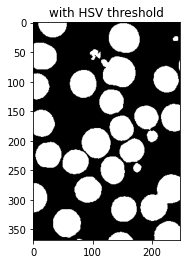

In [436]:
H = (0, 180)
S = (40, 255)
V = (0, 255)
# For HSV, hue range is [0,179], saturation range is [0,255], and value range is [0,255].

img = cv.imread('c3.jpg')
img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV).copy()
# plt.imshow(img_hsv)
# plt.show() 
# based on above img, compared with the color space cylindar of hsv value, saturation is what differentiate the background and the fore
H = img_hsv[:,:,0] # where hsv is 3 channel (list of list of list), so go down twice [:,:hsv here] , for grayscale, it is [:,here]
S = img_hsv[:,:,1]
V = img_hsv[:,:,2]
mask = (S < 40) # e.g. (S < 40) & (H > 1) 
img_hsv[mask] = 0
img_hsv[S >=40] = 255
plt.title("with HSV threshold")
plt.imshow(img_hsv)
plt.show()

# Task 2: Counting the number of cells (5 marks)

## median filter 

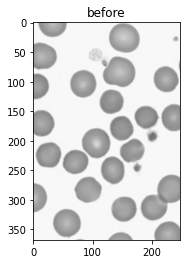

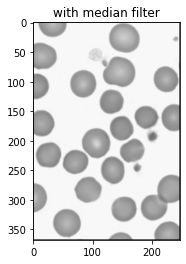

In [452]:
'''
@definition - find all neghtbour and itself within kernel size and change to that median value
ignore the outer pixels depends on the kernel size
'''
def median_filter(img, window_width, window_height):
    # asusme gray scale
    height, width = img.shape
    window = [0 for i in range(window_width * window_height)]
    res = np.zeros((height, width), dtype = 'uint8')
    expandx = int(window_width / 2) 
    expandy = int(window_height / 2) 
    
    for x in range(expandx, width - expandx):
        for y in range(expandy, height - expandy):
            i = 0
            for xw in range(window_width):
                for yw in range(window_height):
                    window[i] = img[y + yw - expandy][x + xw - expandx]
                    i += 1
            window.sort()
            res[y][x] = window[int(window_width * window_height / 2)]
    
    return res

    
gray = cv.imread('c3.jpg',0)
plt.figure(0)
plt.title("before")
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))
img_medianf = median_filter(gray, 3, 3)
plt.figure(1)
plt.title("with median filter")
plt.imshow(cv.cvtColor(img_medianf, cv.COLOR_BGR2RGB))


##  two pass connected components

In [429]:


'''
0 - black: foreground
255 - white: background
'''
def is_background(pixel):
    return pixel == 0

'''
4-neighbourhood up, down, left, right
-1 if not labeled / background
-2 if idx out of bound - no neighbour
Consider two pixels to be adjacent if they share the same colour / intensity and each belongs to the other’s four-neighbourhood

@return list of labels
'''
def get_neighbours(labels, r, c, pixel, img):
    
    not_exist = 0 # invalid position
    rows = labels.shape[0]
    cols = labels.shape[1]
    
    up = down = left = right = not_exist
    
    if r - 1 >= 0 and img[r-1][c] == pixel:
        up = labels[r-1][c] # neighbor elements whose labels are not assigned yet are ignored
    if r + 1 < rows and img[r+1][c] == pixel:
        down = labels[r+1][c]
    if c - 1 >= 0 and img[r][c-1] == pixel:
        left = labels[r][c-1]
    if c + 1 < cols and img[r][c+1] == pixel:
        right = labels[r][c+1]
    
    if up == down == right == left == not_exist: # no neighbou
        return np.array([])
    
    # if same intensity
    
    return np.array([up, down, right, left])

'''
add to eq_sets if elements in inserted list not appear in other list in eq_set
otherwise, union two list with no duplicate
@ls list of labels e.g [1,2,3]
@eq_sets - list of list of labels
'''
import itertools

def add_to_eq_sets(eq_sets:list, ls:list):
    idxes = []
    for i, e in enumerate(eq_sets):
        # any element from the input list is in the list in eq sets
        for l in ls:
            if l in e:
                idxes.append(i) # find all lists contain element in the input ls
                break
    if not idxes: # no neighbours
        eq_sets.append(ls)
        return
    # make a merge list
    be_append = [eq_sets[i] for i in idxes]
    be_append = list(set(itertools.chain(*be_append)))
    
    # remove individual lists from eq_sets
    for i in idxes[::-1]: # remove in reverse order to make index persist during deletion
        del eq_sets[i]
    eq_sets.append(be_append)
        
'''
find list contains e, return the min of that list
'''
def get_min_labels(e, ls):
    for i, l in enumerate(ls):
        if e in l:
#             return min(l)
            return i + 1 # idx of equivalence set [1~ n labels]
        
import math
from statistics import median

def two_passed_connected_component(img):
    rows = img.shape[0]
    cols = img.shape[1]
    
    labels = np.zeros((rows, cols)) # store label 
    eq_set = [] # equivalence sets - list of lists
    classes = 1 # start from 1
    
    # first pass
    for c in range(cols):
        
        for r in range(rows):
            pixel = img[r][c]
            
            if is_background(pixel): # ignore
               continue
            
            neighbours = get_neighbours(labels, r,c, pixel, img)
            neighbours = list(neighbours[neighbours > 0]) # ignore 0 - not labeled
            
            if not neighbours: # If there are no neighbors, uniquely label the current element and continue
                labels[r][c] = classes
                classes += 1
                continue
            
            labels[r][c] = min(neighbours) # Otherwise, find the neighbor with the smallest label and assign it to the current element
            add_to_eq_sets(eq_set, neighbours)
    
    # store area (number of pixels) for each label
    areas = [0 for i in range(len(eq_set))]
    
    # second pass
    for c in range(cols):
        
        for r in range(rows):
            if is_background(img[r][c]): # ignore
               continue
            # find the list contain the label of current pixel in the eq_sets
            # assign the min
            lb = get_min_labels(labels[r][c], eq_set)
            
            if not lb or math.isnan(lb): # aviod none type
                continue
            labels[r][c] = lb
            areas[int(lb) - 1] += 1 # -1  starts from 0, label starts from 1
            
    # callobrate
    print("median(areas) before nomalised", median(areas))
    
    # normalised - remove obvious small cell, assume any large cell (e.g. 10x larger) are overlapped cell (overlap of two)
    normalised_thresh = 0.5 * median(areas) # median with outier (noise)
    print("normalised_thresh", normalised_thresh)
    normalised_areas = [i for i in areas if i >= normalised_thresh] 
    
    
    min_ara_thresh = 0.65 * median(normalised_areas)
    print("min_ara_thresh", min_ara_thresh)
    max_area_thresh = 2 * median(normalised_areas) # 
    print("max_area_thresh", max_area_thresh)
    
    # remove small cells 
    new_areas = [i for i in normalised_areas if i >= min_ara_thresh] 
    # double overlap cells
    count_cell = 0
    for i in new_areas:
        if i >= max_area_thresh:
            count_cell += 2 # assume max two  overlaps
        
        count_cell += 1
        
    print("count_cell", count_cell)
    print(sorted(new_areas))
    return count_cell
    
count_labels = two_passed_connected_component(img_binary)

median(areas) before nomalised 848
normalised_thresh 424.0
min_ara_thresh 828.1
max_area_thresh 2548.0
count_cell 29
[836, 848, 873, 959, 1001, 1040, 1061, 1114, 1126, 1150, 1170, 1207, 1209, 1268, 1280, 1300, 1329, 1334, 1350, 1393, 1412, 1453, 1462, 1608, 1632, 1650, 1655, 1758, 1763]


# benchmark on four images
if load four at the same time, takes about 1min

thresh 202
median(areas) before nomalised 869
normalised_thresh 434.5
min_ara_thresh 854.75
max_area_thresh 2630
count_cell 51
[869, 878, 920, 955, 993, 1020, 1032, 1068, 1073, 1111, 1127, 1139, 1165, 1185, 1206, 1208, 1212, 1220, 1231, 1236, 1254, 1279, 1315, 1336, 1352, 1361, 1392, 1396, 1419, 1423, 1427, 1489, 1496, 1550, 1566, 1582, 1593, 1618, 1636, 1662, 1667, 1798, 1872, 1918, 1935, 1955, 2411, 2591, 2688]
thresh 202
median(areas) before nomalised 327.5
normalised_thresh 163.75
min_ara_thresh 624.0
max_area_thresh 1920.0
count_cell 35
[685, 899, 913, 937, 983, 1016, 1078, 1137, 1142, 1142, 1160, 1197, 1199, 1263, 1271, 1284, 1309, 1314, 1328, 1338, 1342, 1360, 1363, 1372, 1446, 1502, 1518, 1549, 1582, 1596, 1631, 1729, 1734, 1750, 1800]
thresh 202
median(areas) before nomalised 1100
normalised_thresh 550.0
min_ara_thresh 827.125
max_area_thresh 2545.0
count_cell 24
[866, 915, 924, 925, 1100, 1103, 1130, 1188, 1205, 1206, 1246, 1253, 1292, 1311, 1389, 1402, 1432, 1433, 1475, 1530

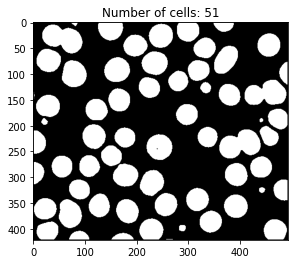

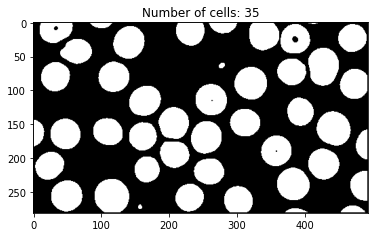

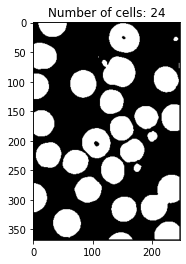

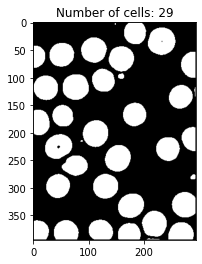

In [431]:
total_image = 4
for i in range(total_image):
    
    gray = cv.imread(f'c{i+1}.jpg',0)
    res = otsu_thresholding(gray)
    img_binary = median_filter(res, 3, 3)
    count_labels = two_passed_connected_component(img_binary)
    plt.figure(i)
    plt.title(f"Number of cells: {count_labels}")
    plt.imshow(img_binary, cmap='gray', vmin=0, vmax=255)
    
plt.show()